# Data Anaylsis

## 1. Import Libraries & Data

### Import Libraries/Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

%matplotlib inline

sns.set_style('ticks')

In [2]:
df = pd.read_csv('./clean_data/merged_tables.csv')

/Users/rezarad/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df = df.drop('Unnamed: 0', axis=1)

In [4]:
df['DATETIME_MTA'] = pd.to_datetime(df['DATETIME_MTA'], format='%Y-%m-%d %H:%M:%S')

In [5]:
df['DAY'] = df['DATETIME_MTA'].apply(lambda x: x.dayofyear)

In [6]:
df['HOUR'] = df['DATETIME_MTA'].apply(lambda x: x.hour)

In [7]:
df = df.loc[df['DATETIME_MTA'] >= pd.datetime(2017, 1, 1)]

In [22]:
df = df.dropna()

In [8]:
df.dtypes

LINENAME                    object
STATION_MTA                 object
DATETIME_MTA        datetime64[ns]
ENTRIES                      int64
EXITS                        int64
GTFS Latitude              float64
GTFS Longitude             float64
STATION_WEATHER             object
STATION_NAME                object
LATITUDE                   float64
LONGITUDE                  float64
DATETIME_WEATHER            object
HOURLYPrecip               float64
DAY                          int64
HOUR                         int64
dtype: object

In [9]:
df.shape

(7197286, 15)

## 2. Data Exploration

In [10]:
df.sample(5)

,LINENAME,STATION_MTA,DATETIME_MTA,ENTRIES,EXITS,GTFS Latitude,GTFS Longitude,STATION_WEATHER,STATION_NAME,LATITUDE,LONGITUDE,DATETIME_WEATHER,HOURLYPrecip,DAY,HOUR
212054,1,14TH STREET,2017-04-11 07:13:30,459,4,40.737826,-74.000201,WBAN:94789,JFK INTERNATIONAL AIRPORT NY US,40.6386,-73.7622,2017-04-11 07:51:00,0.0,101,7
6904663,NRW,28 ST,2017-01-02 23:00:00,43,38,40.743070,-73.984264,WBAN:94728,NY CITY CENTRAL PARK NY US,40.7889,-73.9669,2017-01-02 23:59:00,0.0,2,23
5392512,F,AVENUE U,2017-01-10 00:00:00,3,0,40.596063,-73.973357,WBAN:14732,LA GUARDIA AIRPORT NY US,40.7792,-73.8800,2017-01-10 00:51:00,0.0,10,0
3174483,6,23 ST,2017-04-06 09:00:00,241,357,40.745906,-73.998041,WBAN:94789,JFK INTERNATIONAL AIRPORT NY US,40.6386,-73.7622,2017-04-06 09:49:00,0.0,96,9
4884726,C,VAN SICLEN AVE,2017-01-24 16:00:00,133,339,40.678024,-73.891688,WBAN:94789,JFK INTERNATIONAL AIRPORT NY US,40.6386,-73.7622,2017-01-24 16:00:00,0.0,24,16


In [23]:
print "Len 1: {0} + Len 2: {1} = Total: {2}".format(len(df.loc[df['HOURLYPrecip'] > 0, 'ENTRIES']),
                                                    len(df.loc[df['HOURLYPrecip'] == 0, 'ENTRIES']),
                                                    len(df))

Len 1: 1097884 + Len 2: 4909212 = Total: 6007096


In [33]:
print 'With Precipitation:\n{0}'.format(df.loc[df['HOURLYPrecip'] > 0, ['ENTRIES', 'EXITS']].agg([np.mean, np.std]))
print 'Without Precipitation:\n{0}'.format(df.loc[df['HOURLYPrecip'] == 0, ['ENTRIES', 'EXITS']].agg([np.mean, np.std]))

With Precipitation:
         ENTRIES       EXITS
mean  188.761356  141.613214
std   215.734354  174.362745
Without Precipitation:
         ENTRIES       EXITS
mean  180.857869  136.764057
std   223.012668  179.551911


There seems to be a slight decrease in ridership when theres 'precipitation' vs. 'no precipitation'. Let's explore whether there's a relationship dependent on the amount of precipitation.

## 3. Linear Regression Model

In [158]:
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import Normalizer

#### Grouping the Data by the Hour

In [64]:
gb_day_hr = df.loc[:, ['DAY', 'HOUR', 'HOURLYPrecip', 'ENTRIES', 'EXITS']].groupby(['DAY','HOUR']).mean()

In [162]:
df.columns

Index([u'LINENAME', u'STATION_MTA', u'DATETIME_MTA', u'ENTRIES', u'EXITS',
       u'GTFS Latitude', u'GTFS Longitude', u'STATION_WEATHER',
       u'STATION_NAME', u'LATITUDE', u'LONGITUDE', u'DATETIME_WEATHER',
       u'HOURLYPrecip', u'DAY', u'HOUR'],
      dtype='object')

In [157]:
no_rain = gb_day_hr.loc[gb_day_hr['HOURLYPrecip'] == 0]
rain = gb_day_hr.loc[gb_day_hr['HOURLYPrecip'] != 0]

#### Linear Regression Plot

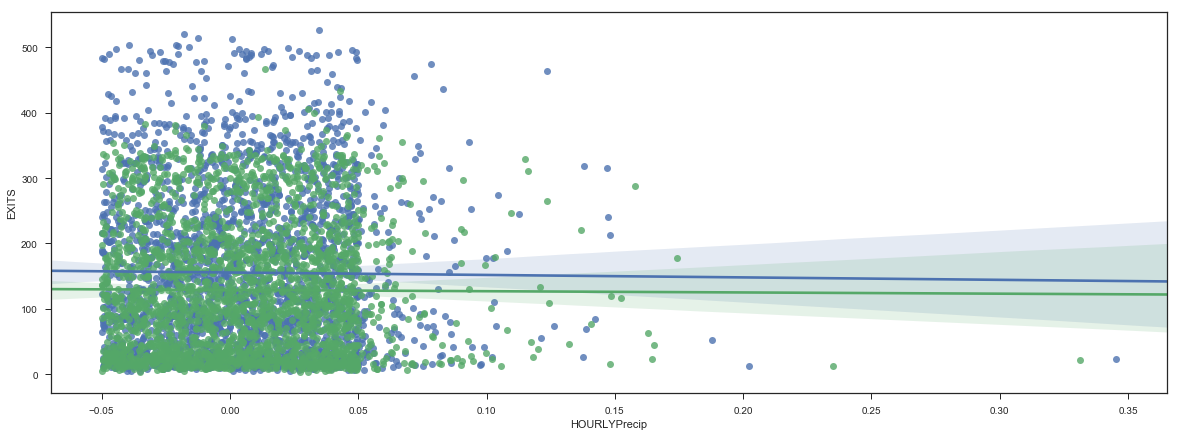

In [80]:
plt.figure(figsize=(20,7))
sns.regplot(x="HOURLYPrecip",
            y="ENTRIES",
            ci=90,
            x_jitter=0.05,
            data=gb_day_hr)
sns.regplot(x="HOURLYPrecip",
            y="EXITS",
            ci=90,
            x_jitter=0.05,
            data=gb_day_hr)
plt.show()

In [98]:
df_x = np.log1p(gb_day_hr['HOURLYPrecip'].values.reshape(-1,1))
df_y = gb_day_hr['ENTRIES'].values

In [102]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.normalize = True
regr.fit(df_x, df_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

('Coefficients: \n', array([-25.80117679]))
Mean squared error: 15597.09
Variance score: 0.00


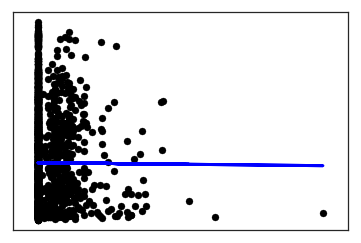

In [103]:
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(df_x) - df_y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(df_x, df_y))

# Plot outputs
plt.scatter(df_x, df_y,  color='black')
plt.plot(df_x, regr.predict(df_x), color='blue',
         linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()